# Install dependencies

In [1]:
!pip install geopandas pyproj shapely geovoronoi

     |████████████████████████████████| 1.0 MB 6.7 MB/s 
     |████████████████████████████████| 6.3 MB 28.5 MB/s 
     |████████████████████████████████| 16.7 MB 38.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


* Create a voronoi diagram over the US creating polygons
* around each of the 49 cities.
* Load said polygons into a spatial tree (geopandas rtree).
* Load each of the UFO sighting points into the same rtree.
* Query the rtree getting the UFO sighting points that are contained within each polygon.
* Save your results to a json file to be used later (maybe).



# Import libraries

In [2]:
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from pyproj import Transformer

from shapely.ops import unary_union

from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords


# Conversion of geopandas dataframe

In [18]:
cities = gpd.read_file("/content/drive/MyDrive/Spatial DS/P03/data/cities.geojson")

ufodata = pd.read_csv("/content/drive/MyDrive/Spatial DS/P03/data/BetterUFOData.csv")

ufogdf = gpd.GeoDataFrame(ufodata, geometry = gpd.points_from_xy(ufodata.lon, ufodata.lat), crs = "EPSG:4326")
    
ufogdf = ufogdf.to_crs(epsg =3395)

# Plot cities

(-127.62233794999996, -64.06073104999999, 23.271492199999997, 50.6278278)

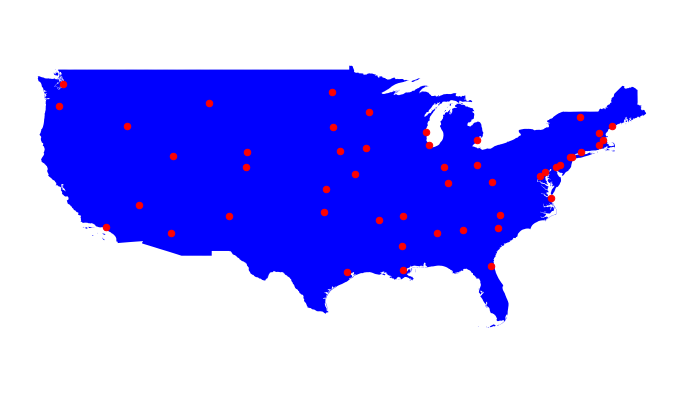

In [24]:
# borders shape file
border = gpd.read_file("/content/drive/MyDrive/Spatial DS/P03/data/us_border_shp/us_border.shp")

# matplotlib plot
fig, ax = plt.subplots(figsize = (12, 7))

border.plot(ax=ax, color = "blue")

cities.plot(ax=ax, markersize=42, color = "red")
ax.axis("off")
plt.axis('equal')

# Output new geojson for cities

In [25]:
spatialIdx = gpd.GeoSeries(ufogdf["geometry"])

cityDictResults = [] 

# project points to specific output projection system
# epsg : specifies output projection
transformer = Transformer.from_crs("epsg:3395", "epsg:4326")


for i in range(len(cities)):

    cityDict = { "city" : cities["city"][i],
                 "polygon": [],
                 "ufos": [] 
                 }

    results = spatialIdx.within(region_polys[i])
    
    for j in range(len(results)):
        if results[j]:
            cityDict["ufos"].append([ufodata["geometry"][j].x,
                                     ufodata["geometry"][j].y
                                     ])

    if region_polys[i].geom_type == 'Polygon':

        for x,y in region_polys[i].exterior.coords:
            x1,y1 = transformer.transform(x,y)
            cityDict["polygon"].append([x1,y1])

    elif region_polys[i].geom_type == 'MultiPolygon':
        points = []
        pointstoList = []
        
        for polygon in (region_polys[i]):

            points.extend(polygon.exterior.coords[:-1])
            pointstoList = list(map(list, points))

            for x, y in pointstoList:

                x1,y1 = transformer.transform(x,y)
                cityDict["polygon"].append([x1,y1])
    
    cityDictResults.append(cityDict)       
    
with open("city-results.json", 'w') as wr:
    wr.write(json.dumps(cityDictResults))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


# Plot voronoi

/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


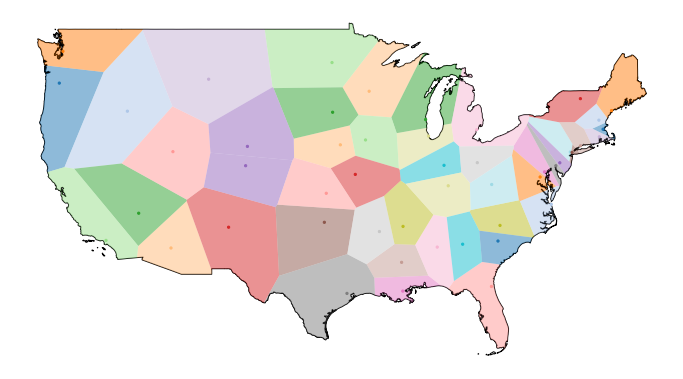

In [26]:
#epsg : specifies output projection
border = border.to_crs(epsg=3395)
cities_proj = cities.to_crs(border.crs)

# convert points to coords
border_shape = unary_union(border.geometry)
coords = points_to_coords(cities_proj.geometry)

# polygons
region_polys, region_pts = voronoi_regions_from_coords(coords,border_shape)

# create and plot voronoi diagram
fig, ax = subplot_for_map(figsize= (12, 9))

plot_voronoi_polys_with_points_in_area(ax, border_shape, region_polys, coords, region_pts)

fig  = plt.gcf()

fig.savefig('voronoi-result.png')
plt.show()
